# 2.5.6: Implementing the Glucose Model

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

## Implementing the Model

### Making a System and a State

The system needs to include not only the parameters but also the data for $I(t)$.   Why?  Our state variables are $G(t)$ and $X(t)$, and $I(t)$ is an assumed set of values affect the $G$ and $X$ levels: the model is trying to understand the behavior of $G$ and $X$ in response to $I$ levels.  

<br>

So first, we need to import this experimental data.  We'll use data from a 1986 paper by Pacini and Bergman, which provides experimental data about glucose and insulin levels for 3 hours after a FSIGT test:

In [ ]:
import pandas as pd
import numpy as np

filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/glucose_insulin.xlsx'
data = pd.read_excel(filename, index_col=0)
data.columns = ['glucose', 'insulin']
data.insulin.head()

130.0

Now we can make the system.  The parameters are an educated guess, and notice that we are setting the base values of glucose and insulin here by assuming that the patient is at these base levels just before the injection.

In [ ]:
# Define parameters
G0 = 270
X0 = 0
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05

# Define simulation parameters based on data
t_0 = data.index[0]
t_end = data.index[-1]
Gb = data.glucose[t_0]
Ib = data.insulin[t_0]
dt = (t_end-t_0)/(data.glucose.size -1)

# The system needs an initial state object called 'init' because we'll
# use that later
state = pd.Series(dict(G=G0, X=X0),dtype=np.float64)
system = dict(init=state, k1=k1,k2=k2,
                  k3=k3,dt=dt, Gb=Gb, Ib=Ib, I=data.insulin,
                  t_0=t_0, t_end=t_end)

### Defining a Change Function

The minimal model is expressed in terms of differential equations:

<br>

$$\frac{dG}{dt} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t)$$

<br>

$$\frac{dX}{dt} = k_3 \left[I(t) - I_b \right] - k_2 X(t)$$

<br>

To simulate this system, we will rewrite them as difference equations.
If we multiply both sides by $dt$, as we have done before, we have:

<br>

$$dG = \left[ -k_1 \left[ G(t) - G_b \right] - X(t) G(t) \right] dt$$

<br>

$$dX = \left[ k_3 \left[I(t) - I_b \right] - k_2 X(t) \right] dt$$

<br>

If we think of $dt$ as a small step in time, these equations tell us how to compute the corresponding changes in $G$ and $X$.  Here's an change function that computes these changes:

In [ ]:
def change_func(t, state, system):
    # Comment 1
    G, X = state
    k1, k2, k3, dt = system['k1'],system['k2'], system['k3'], system['dt']
    I, Ib, Gb = system['I'], system['Ib'], system['Gb']

    # Comment 2
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I[t] - Ib) - k2 * X

    # Comment 3
    state.G += dGdt * dt
    state.X += dXdt * dt

    # Comment 4
    return state

We've seen code like this before: this function returns the updated state object return value with the new values of `G` and `X`.  Before running the simulation, it is a good idea to run the change function with the initial conditions:

In [ ]:
change_func(system['t_0'], state, system)

G    262.88
X      0.00
dtype: float64

If it runs without errors and there is nothing obviously wrong with the results, we are ready to run the simulation.

---

<br>

🟨 🟨 Active Reading

Add inline documentation to the change_func above.  Add one line of documentation for each section of code.

<br>

---

### Simulating Glucose Levels

We'll use the following version of `run_simulation`:

In [ ]:
def run_simulation(system, state, change_func):
    t_array = np.arange(system['t_0'], system['t_end']+1, system['dt'])
    n = len(t_array)

    results = pd.DataFrame(index=t_array, columns=state.index,
                        dtype=np.float64)
    results.iloc[0] = state

    for i in range(n-1):
        t = t_array[i]
        results.iloc[i+1] = change_func(t, state, system)

    return results

Notice that we are storing the state ($G$ and $X$) at each time step with a DataFrame. When we make the DataFrame, we use `index` to indicate that the index is the array of time steps, `t_array`, and `columns` to indicate that the column names are the state variables.

<br>

We can run it like this, and it returns a DataFrame with a row for each time step and a column for each of the state variables, `G` and `X`.

In [ ]:
results = run_simulation(system, state,change_func)
results.head()

,G,X
0.0,262.880000,0.000000
2.0,256.044800,0.000000
4.0,249.483008,0.000450
6.0,242.959153,0.004002
8.0,234.976142,0.006062


The following plot shows the simulated glucose levels from the model along with the measured data.

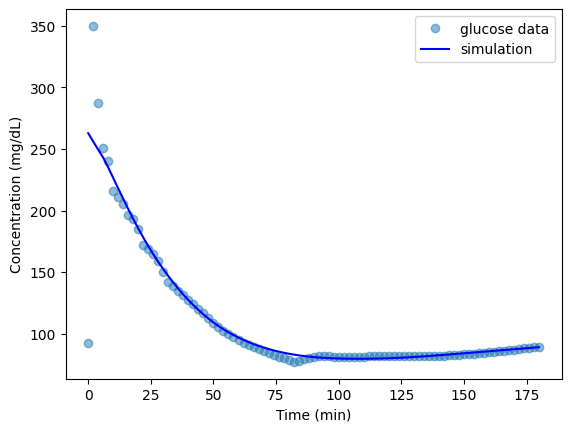

In [ ]:
data.glucose.plot(style='o', alpha=0.5, label='glucose data',legend=True)
results.G.plot(style='-', color='blue', label='simulation',legend=True,
               xlabel='Time (min)',
               ylabel='Concentration (mg/dL)');

With the parameters we chose, the model fits the data well except during the first few minutes after the injection.
But we don't expect the model to do well in this part of the time series.  The problem is that the model is *non-spatial*; that is, it does not
take into account different concentrations in different parts of the
body. Instead, it assumes that the concentrations of glucose and insulin in blood, and insulin in tissue fluid, are the same throughout the body. This way of representing the body is known among experts as the "bag of blood" model.

<br>

Immediately after injection, it takes time for the injected glucose to
circulate. During that time, we don't expect a non-spatial model to be
accurate. For this reason, we should not take the estimated value of `G0` too seriously; it is useful for fitting the model, but not meant to correspond to a physical, measurable quantity.

### Simulating the Level of Insulin in the Tissue

Remember that $I$ represents the insulin levels in the blood, while $X$ represents the levels in the tissue fluid, where it actually does the work of reducing glucose.  The following plot shows simulated insulin levels $X$ in the tissue, which is in unspecified units:

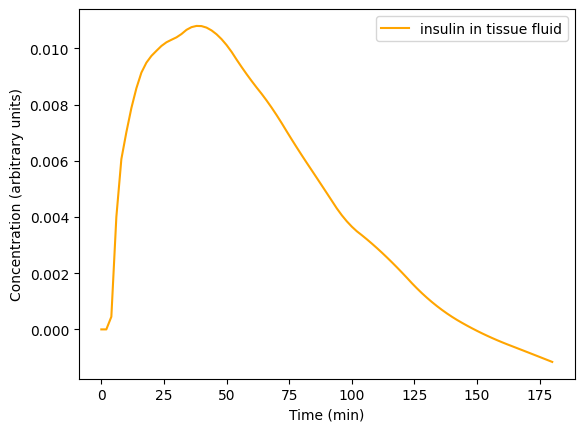

In [ ]:
results.X.plot(color='orange', label='insulin in tissue fluid',
               xlabel='Time (min)',
               ylabel='Concentration (arbitrary units)',
               legend=True);

Remember that `X` represents the concentration of insulin in the "remote compartment", which is believed to be tissue fluid, so we can't compare it to the measured concentration of insulin in the blood.  `X` rises quickly after the initial injection and then declines as the concentration of glucose declines.  Qualitatively, this behavior is as expected, but because `X` is not an observable quantity, we can't validate this part of the model quantitatively.

## Exercises

---

<br>

🟨 🟨

### Exercise 1

There are two terms on the right hand side of the equation for $G$ (glucose):

<br>$$\frac{dG}{dt} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t)$$

<br> Look at the plot above of $G$ (the blue one).  From 0-25 s, the level of $G$ decreases very quickly.Remembering that all the $k$ constants are positive, which of the right hand side terms (or both?) is driving the glucose down in the first part of the model?  Consider the signs of the term (negative/ positive), and the size of $G(t)$ and $X(t)$ during that time period.

✅ ✅  Put your answer here.

---

<br>

🟨 🟨

### Exercise 2

There are two terms on the right hand side of the equation for $X$ (insulin in the tissue):

<br> $$\frac{dX}{dt} = k_3 \left[I(t) - I_b \right] - k_2 X(t)$$

<br> Look at the plot above (the orange one).  From 0-25 s, the level of $X$ increases very quickly.  Which of the two terms is responsible for driving the rapid increase in $X$ in the first part of the simulation?  Consider the signs of the term (negative/ positive), and the size of $I$ and $X$ during that time period.

✅ ✅  Put your answer here.